In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import os, yaml, pickle, tqdm, glob

from muller_utils import success_cluster_identification, reconstruct_energy
from realsys_utils import *

# Load data

In [6]:
directory = 'results/peptide/GradNav/run_240216_1637'
directory_md = 'results/peptide/MD'
params = yaml.load(open(os.path.join(directory,'param.yaml'), 'r'), Loader=yaml.FullLoader)
init_traj_index = params['init_traj_index']
large_batch_size = params['large_batch_size']
small_batch_size = params['small_batch_size']
threshold = params['threshold']
feature1_path = params['feature1_path']
feature2_path = params['feature2_path']
feature1 = pd.read_pickle(feature1_path) # a9
feature2 = pd.read_pickle(feature2_path) #20
traj = combine_trajectories(feature1, feature2)


result = pd.read_pickle(os.path.join(directory,'results.pkl'))
all_traj = result['all_traj']
all_traj_stacked = np.vstack(all_traj)
outer = result['outer']
inner = result['inner']
iteration_counter = result['iteration_counter']
iteration_counter_list = iteration_counter_converter(iteration_counter)
coord_index = result['coord_index']

In [7]:
proposed_inits, new_inits, prev_lasts, updates = get_data_for_figures(inner)

In [8]:
center_points = np.array([[1.61, 2.52], [2.45, 2.52], 
                          [1.6, 1.67], [2.47, 1.67]])

x_limits = [1.25, 2.95]
y_limits = [1.25, 2.95]
x_label='ALA9 O-C-N angle (rad)'
y_label='ARG20 CB-CD-NE angle (rad)'
ft=18
label_1 = 'MD'
label_2 = 'GradNav'

# MD

## Trajectory

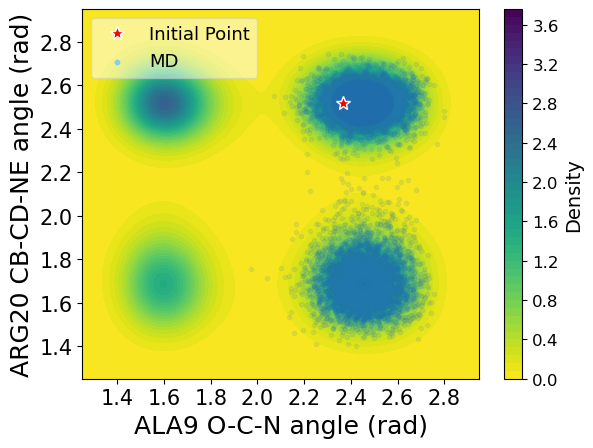

In [9]:
#init_traj_index = 4 #15
density_contour(traj[15], xlabel=x_label, ylabel=y_label, fontsize=ft-4)
plt.scatter(traj[init_traj_index][:,0], traj[init_traj_index][:,1], 
            marker='.', 
            #edgecolors='blue',
            alpha=0.1) #, c='orange')
plt.plot(traj[init_traj_index][0, 0], traj[init_traj_index][0, 1], '*', 
         markeredgecolor='white', color='r', 
         markersize=10, label='Initial Point')
plt.scatter([], [], c='skyblue', label=label_1, s=10)
plt.xlim(x_limits)
plt.ylim(y_limits)
plt.xticks(fontsize=ft-3)
plt.yticks(fontsize=ft-3)
plt.legend(fontsize=ft-5, loc='upper left',framealpha=0.5)
plt.xlabel(x_label, fontsize=ft)
plt.ylabel(y_label, fontsize=ft)
plt.savefig(os.path.join(directory_md, 'all_data_MD.png'), 
            dpi=300, bbox_inches='tight')

## DWEF

In [10]:
# Initialize the list and average calculation
# indices that show the switching between the two ALA-O-C-N angles
switching_index_list = [2, 3, 6, 7, 8, 9, 13, 15, 19, 22, 23, 26, 28]

dwe_frame_avg = 0 
output_lines = []  # List to hold output lines for writing to file

for idx in switching_index_list:
    dwe_frame = find_shift_index(traj[idx], 'x', 1.9, 10)
    output_lines.append(f'Run {idx}: {dwe_frame}\n')
    dwe_frame_avg += dwe_frame
dwe_frame_avg = dwe_frame_avg / len(switching_index_list)
output_lines.append(f'Average DWEF: {dwe_frame_avg}\n')

# Writing results to a text file
with open(os.path.join(directory_md, 'dwef.txt'), 'w') as file:
    file.writelines(output_lines)

## SSIR

In [11]:
total_num_success = 0
total_num_clusters = 0
valid_init = []

for i in tqdm.tqdm(range(1,29)):
    init = traj[i][0]
    num_identified_cluster = success_cluster_identification(traj[i], 
                                                            center_points, 
                                                            distance_threshold=0.1, 
                                                            number_threshold=5)
    total_num_success += num_identified_cluster
    total_num_clusters += len(center_points)
    init = np.append(init, num_identified_cluster)
    valid_init.append(init)

valid_init = np.array(valid_init)
ssir = total_num_success / total_num_clusters 
print(ssir)
# save ssir and valid_init
with open(os.path.join(directory_md, 'ssir_md.txt'), 'w') as f:
    f.write(f'{ssir:.3f}')

with open(os.path.join(directory_md, 'valid_init_md.pkl'), 'wb') as f:
    pickle.dump(valid_init, f)

100%|██████████| 28/28 [00:03<00:00,  7.70it/s]


In [13]:
# import valid_init
with open(os.path.join(directory_md, 'valid_init_md.pkl'), 'rb') as f:
    valid_init = pickle.load(f)

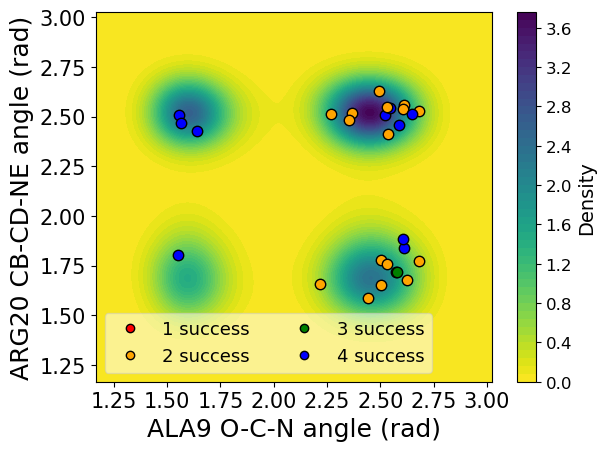

In [14]:
# Define colors for each value
colors = {1: 'red', 2: 'orange', 3: 'green', 4: 'blue'}

density_contour(traj[15], xlabel=x_label, ylabel=y_label, fontsize=ft-4)

# Loop through each point and plot it with the corresponding color
for point in valid_init:
    plt.plot(point[0], point[1], '.', 
             color=colors[point[-1]], markeredgecolor='black', markersize=15)
    # plt.text(point[0], point[1], f'{point[3]}', color='black', fontsize=9, ha='right', va='bottom')
    #plt.text(point[0], point[1], f'{int(point[3])}', color='black', fontsize=11) #, ha='right', va='bottom')
for i in range(len(colors)):
    plt.plot([], [], '.', color=list(colors.values())[i], 
             markeredgecolor='black', markersize=12, label=f'{i+1} success')
plt.legend(fontsize=ft-5, loc='lower left', framealpha=0.5, ncol=2)
plt.xticks(fontsize=ft-3)
plt.yticks(fontsize=ft-3)
plt.xlabel(x_label, fontsize=ft)
plt.ylabel(y_label, fontsize=ft)
plt.savefig(os.path.join(directory_md, 'ssir_md.png'), 
            dpi=300, bbox_inches='tight')

# GradNav

## Trajectory

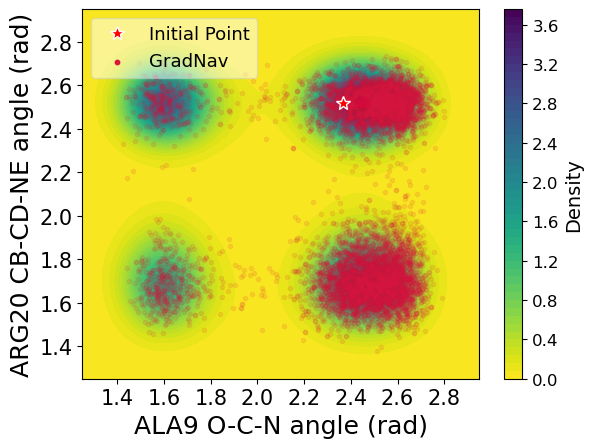

In [15]:
# init_traj_index = 4 #15
color = 'crimson'
density_contour(traj[15], xlabel=x_label, ylabel=y_label,fontsize=ft-4)
plt.scatter(all_traj_stacked[:,0], all_traj_stacked[:,1], 
            marker='.', 
            #edgecolors='blue',
            c=color,
            alpha=0.1) 
plt.plot(traj[init_traj_index][0, 0], traj[init_traj_index][0, 1], '*', 
         markeredgecolor='white', color='r', 
         markersize=10, label='Initial Point')
plt.scatter([], [], c=color, label=label_2, s=10)
plt.xlim(x_limits)
plt.ylim(y_limits)
plt.xticks(fontsize=ft-3)
plt.yticks(fontsize=ft-3)
plt.legend(fontsize=ft-5, loc='upper left', framealpha=0.5)
plt.xlabel(x_label, fontsize=ft)
plt.ylabel(y_label, fontsize=ft)

plt.savefig(os.path.join(directory, 'all_data_GradNav.png'), 
            dpi=300, bbox_inches='tight')

## Outer loop trajectories

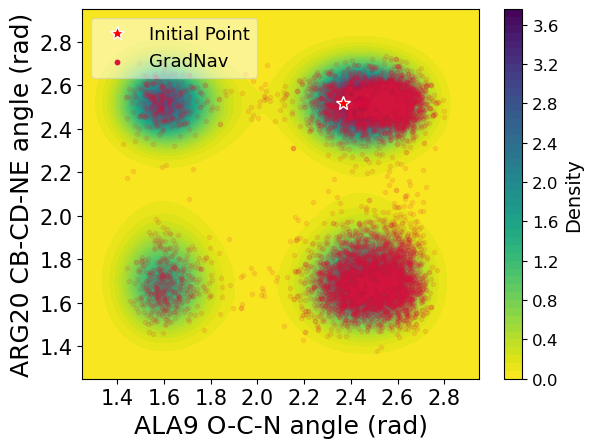

In [16]:
outer_loop_trajs = [all_traj[start_index] for start_index, _ in iteration_counter_list]
outer_loop_trajs = np.vstack(outer_loop_trajs)


color = 'crimson'
density_contour(traj[15], xlabel=x_label, ylabel=y_label, fontsize=ft-4)
plt.scatter(outer_loop_trajs[:,0], outer_loop_trajs[:,1], 
            marker='.', 
            #edgecolors='blue',
            c=color,
            alpha=0.1) 
plt.plot(traj[init_traj_index][0, 0], traj[init_traj_index][0, 1], '*', 
         markeredgecolor='white', color='r', 
         markersize=10, label='Initial Point')
plt.scatter([], [], c=color, label=label_2, s=10)
plt.xlim(x_limits)
plt.ylim(y_limits)
plt.xticks(fontsize=ft-3)
plt.yticks(fontsize=ft-3)
plt.legend(fontsize=ft-5, loc='upper left', framealpha=0.5)
plt.xlabel(x_label, fontsize=ft)
plt.ylabel(y_label, fontsize=ft)

plt.savefig(os.path.join(directory, 'outer_data_GradNav.png'), 
            dpi=300, bbox_inches='tight')

## DWEF

In [17]:
shift_threshold = 1.8
number_threshold = 20

dwef_gradnav = find_shift_index(outer_loop_trajs, 'x', shift_threshold, number_threshold)
print(dwef_gradnav)

# save results
with open(os.path.join(directory, f'dwef{dwef_gradnav}.txt'), 'w') as file:
    file.write(f'{dwef_gradnav}\n')

3065


## Update rate

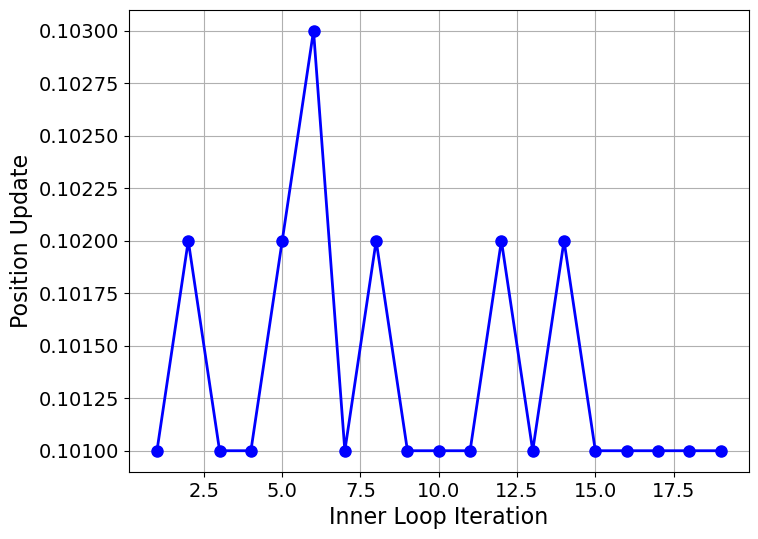

In [18]:
# Create the plot
plt.figure(figsize=(8, 6))  # Set the figure size

# Plot the data
iteration = np.arange(1, len(updates) + 1)
plt.plot(iteration, updates, marker='o', linestyle='-', color='b', markersize=8, linewidth=2)

# Add labels and title
plt.xlabel('Inner Loop Iteration', fontsize=ft-2)
plt.ylabel('Position Update', fontsize=ft-2)
# plt.title('Position Update vs. Iteration', fontsize=16)

# Increase the tick label font size
plt.xticks(fontsize=ft-4)
plt.yticks(fontsize=ft-4)

# Add gridlines
plt.grid(True)

# Save the plot as an image (optional)
plt.savefig(os.path.join(directory, 'update_rate.png'), 
            dpi=300, bbox_inches='tight')

## Update arrow (proposed)

The arrows delineate the proposed points as per the GradNav algorithm.

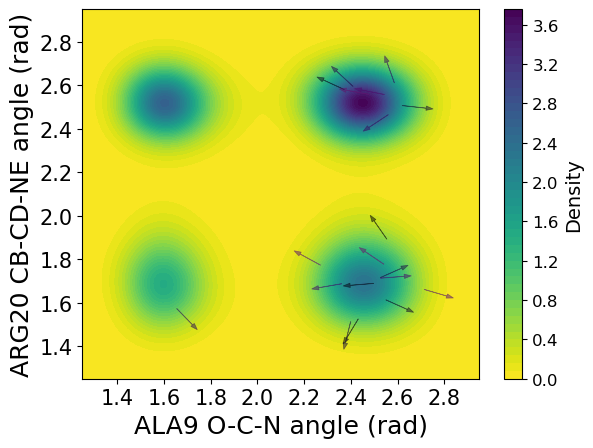

In [19]:
colors = cm.inferno(np.linspace(0, 0.8, len(all_traj)))
density_contour(traj[15], xlabel=x_label, ylabel=y_label,fontsize=ft-4)
i = 0
for prev, upd in zip(prev_lasts, proposed_inits): 
    c = colors[i]
    x_prev, y_prev = prev
    x_upd, y_upd = upd
    plt.arrow(x_prev, y_prev, x_upd-x_prev, y_upd-y_prev, 
              color=c, head_width = .02, linewidth=0.5, alpha=0.5)
    i += 1
plt.xlim(x_limits[0], x_limits[1])
plt.ylim(y_limits[0], y_limits[1])
plt.xticks(fontsize=ft-3)
plt.yticks(fontsize=ft-3)
plt.xlabel(x_label, fontsize=ft)
plt.ylabel(y_label, fontsize=ft)
plt.savefig(os.path.join(directory, 'arrow_proposed.png'), 
            dpi=300, bbox_inches='tight')

# Update arrow (actual)

The arrows depict the actual points acquired through pseudo-molecular simulation methodology.

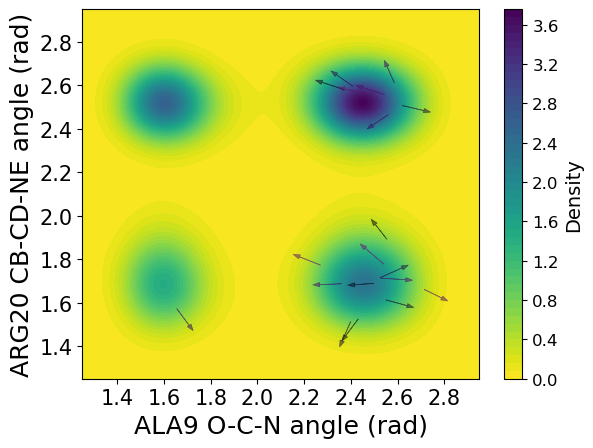

In [20]:
colors = cm.inferno(np.linspace(0, 0.8, len(all_traj)))
density_contour(traj[15], xlabel=x_label, ylabel=y_label, fontsize=ft-4)
i = 0
for prev, upd in zip(prev_lasts, new_inits): 
    c = colors[i]
    x_prev, y_prev = prev
    x_upd, y_upd = upd
    plt.arrow(x_prev, y_prev, x_upd-x_prev, y_upd-y_prev, 
              color=c, head_width = .02, linewidth=0.5, alpha=0.5)
    i += 1
plt.xlim(x_limits[0], x_limits[1])
plt.ylim(y_limits[0], y_limits[1])
plt.xticks(fontsize=ft-3)
plt.yticks(fontsize=ft-3)
# plt.legend(fontsize=ft-5, loc='upper left', framealpha=0.5)
plt.xlabel(x_label, fontsize=ft)
plt.ylabel(y_label, fontsize=ft)
plt.savefig(os.path.join(directory, 'arrow_actual.png'), 
            dpi=300, bbox_inches='tight')

# Descrepancy between proposed and actual inits

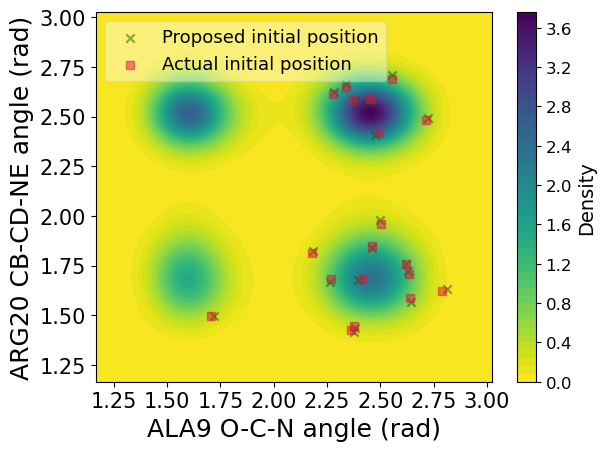

In [21]:
density_contour(traj[15], xlabel=x_label, ylabel=y_label, fontsize=ft-4)
#plt.scatter(prev_lasts[:,0], prev_lasts[:,1], color='blue', marker='.', label='prev last')
plt.scatter(proposed_inits[:,0], proposed_inits[:,1], color='darkgreen', alpha=0.5, marker='x', label='Proposed initial position')
plt.scatter(new_inits[:,0], new_inits[:,1], color='crimson', marker='s', alpha=0.5, label='Actual initial position')
plt.legend(fontsize=ft-5, loc='best', framealpha=0.4)

plt.xticks(fontsize=ft-3)
plt.yticks(fontsize=ft-3)
plt.xlabel(x_label, fontsize=ft)
plt.ylabel(y_label, fontsize=ft)
plt.savefig(os.path.join(directory, 'init_delta.png'), 
            dpi=300, bbox_inches='tight')

# Energy Curve - combined

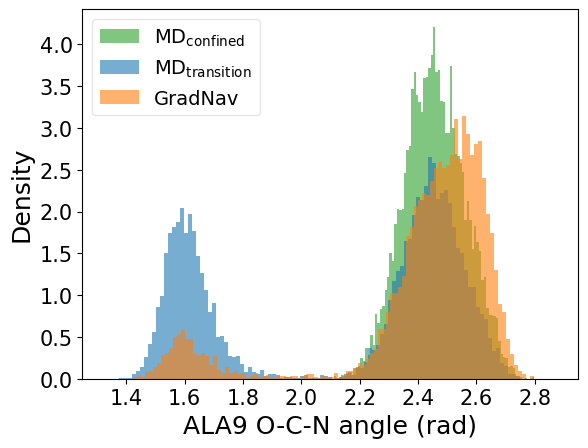

In [22]:
#md_index = init_traj_index #init_traj_index or 15

confined_index = init_traj_index
transition_index = 15 

plt.hist(traj[confined_index][:,0], bins=100, density=True, color='#2ca02c',
         alpha=0.6, label=r'MD$_{\mathrm{confined}}$')
plt.hist(traj[transition_index][:,0], bins=100, density=True, color='#1f77b4',
        alpha=0.6, label=r'MD$_{\mathrm{transition}}$')
plt.hist(all_traj_stacked[:,0], bins=100, density=True, color='#ff7f0e',
         alpha=0.6, label='GradNav')
plt.xlabel(x_label, fontsize=ft)
plt.ylabel('Density', fontsize=ft)
plt.xlim(x_limits)
# plt.title('Distribution of Distance from Start Point')
plt.legend(fontsize=ft-4, loc='best', framealpha=0.5)
plt.xticks(fontsize=ft-3)
plt.yticks(fontsize=ft-3)
plt.savefig(os.path.join(directory, f'histogram_combined.png'), 
            dpi=300, bbox_inches='tight')

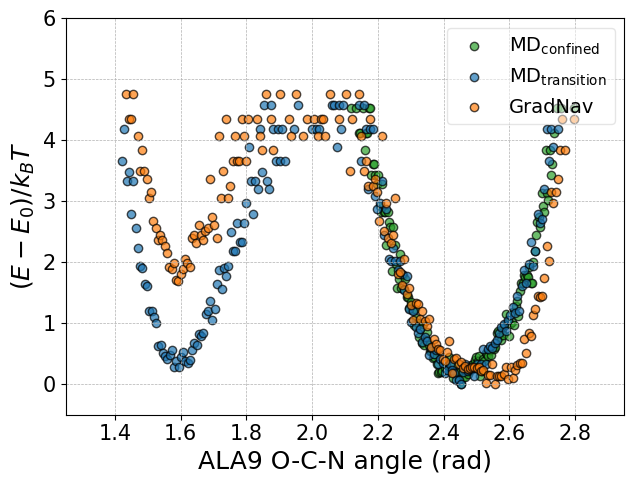

In [23]:

anchors_md_cf, fn_md_cf = reconstruct_energy(traj[confined_index][:,0], 200)
anchors_md_tr, fn_md_tr = reconstruct_energy(traj[transition_index][:,0], 200)
anchors_gradnav, fn_gradnav = reconstruct_energy(all_traj_stacked[:,0], 200)

# Visualize the results with improved aesthetics
plt.scatter(anchors_md_cf, fn_md_cf, alpha=0.7, edgecolor='black', color='#2ca02c', label=r'MD$_{\mathrm{confined}}$')
plt.scatter(anchors_md_tr, fn_md_tr, alpha=0.7, edgecolor='black', color='#1f77b4', label=r'MD$_{\mathrm{transition}}$')
plt.scatter(anchors_gradnav, fn_gradnav, alpha=0.7, edgecolor='black', color='#ff7f0e', label='GradNav')

plt.xlabel(x_label, fontsize=ft)
plt.ylabel(r"$(E - E_0) / k_B T$", fontsize=ft)

# plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.legend(fontsize=ft-4, loc='upper right', framealpha=0.5)
plt.xticks(fontsize=ft-3)
plt.yticks(fontsize=ft-3)
plt.xlim(x_limits)
plt.ylim(-0.5, 6.0)
plt.savefig(os.path.join(directory, f'recon_E_md_combined.png'), 
            dpi=300, bbox_inches='tight')

# SSIR - Initial points on grid

In [25]:
num_step = 10000
command = f"python run_ssir_realsys_GradNav.py --dir {directory.split('/')[-1]} --num_step {num_step}"
!{command}

  0%|                                                    | 0/28 [00:00<?, ?it/s]simulation initialization
-100 frames remain!
cluster transition 1!
simulation termination
  4%|█▌                                          | 1/28 [00:00<00:03,  8.35it/s]simulation initialization
-100 frames remain!
cluster transition 1!
simulation termination
  7%|███▏                                        | 2/28 [00:00<00:03,  6.97it/s]simulation initialization
-100 frames remain!
cluster transition 1!
simulation termination
 11%|████▋                                       | 3/28 [00:00<00:03,  7.45it/s]simulation initialization
-100 frames remain!
cluster transition 1!
simulation termination
 14%|██████▎                                     | 4/28 [00:00<00:03,  7.68it/s]simulation initialization
-100 frames remain!
cluster transition 1!
simulation termination
 18%|███████▊                                    | 5/28 [00:00<00:03,  6.22it/s]simulation initialization
-100 frames remain!
cluster transition 

In [26]:
total_num_success = 0
total_num_clusters = 0
valid_init = []
# path = "results/peptide/ogn/ssir_240212_2053"
#for i in tqdm.tqdm(range(1,5)):
for file in glob.glob(os.path.join(directory, 'ssir', 'traj_*', 'results.pkl')):
    results = pd.read_pickle(file)
    
    iter_traj = results['all_traj']
    iter_traj = np.vstack(iter_traj)
    
    init = iter_traj[0]
    num_identified_cluster = success_cluster_identification(iter_traj[:num_step+1], 
                                                            center_points, 
                                                            distance_threshold=0.1, 
                                                            number_threshold=5)
    total_num_success += num_identified_cluster
    total_num_clusters += len(center_points)
    init = np.append(init, num_identified_cluster)
    valid_init.append(init)

valid_init = np.array(valid_init)
ssir = total_num_success / total_num_clusters 
print(ssir)

0.49107142857142855


In [27]:
# save ssir and valid_init
with open(os.path.join(directory, 'ssir_gradnav.txt'), 'w') as f:
    f.write(f'{ssir:.3f}')

with open(os.path.join(directory, 'valid_init_gradnav.pkl'), 'wb') as f:
    pickle.dump(valid_init, f)

In [28]:
# import valid_init
with open(os.path.join(directory, 'valid_init_gradnav.pkl'), 'rb') as f:
    valid_init = pickle.load(f)

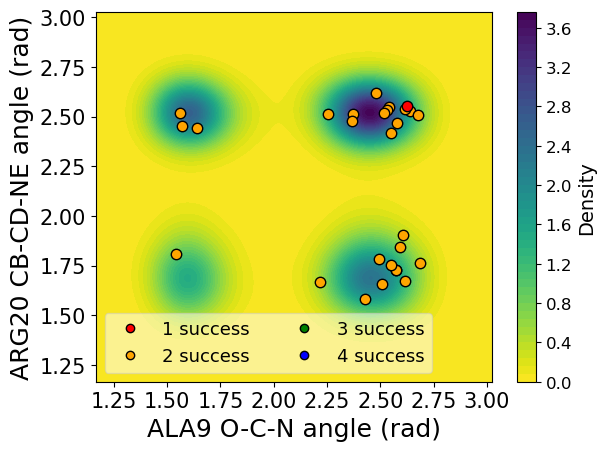

In [29]:
# Define colors for each value
colors = {1: 'red', 2: 'orange', 3: 'green', 4: 'blue'}

density_contour(traj[15], xlabel=x_label, ylabel=y_label, fontsize=ft-4)

# Loop through each point and plot it with the corresponding color
for point in valid_init:
    plt.plot(point[0], point[1], '.', 
             color=colors[point[-1]], markeredgecolor='black', markersize=15)
    # plt.text(point[0], point[1], f'{point[3]}', color='black', fontsize=9, ha='right', va='bottom')
    #plt.text(point[0], point[1], f'{int(point[3])}', color='black', fontsize=11) #, ha='right', va='bottom')
for i in range(len(colors)):
    plt.plot([], [], '.', color=list(colors.values())[i], 
             markeredgecolor='black', markersize=12, label=f'{i+1} success')
plt.legend(fontsize=ft-5, loc='lower left', framealpha=0.5, ncol=2)
plt.xticks(fontsize=ft-3)
plt.yticks(fontsize=ft-3)
plt.xlabel(x_label, fontsize=ft)
plt.ylabel(y_label, fontsize=ft)

plt.savefig(os.path.join(directory, 'ssir_gradnav.png'), 
            dpi=300, bbox_inches='tight')

# RMSD Plot

In [30]:
import mdtraj as md

In [31]:
# Placeholder list to store each extracted segment of trajectories
topology_file = "/home/hoon/boltzmann/brownian/data/Fs_peptide/traj/fs-peptide.pdb"

extracted_segments = []
# Loop through each item in your target indices dictionary
for (traj_num, start_idx, end_idx) in coord_index:
    if end_idx - start_idx == large_batch_size:
        # Construct the XTC filename for the current trajectory
        filename = f"/home/hoon/boltzmann/brownian/data/Fs_peptide/traj/trajectory-{traj_num}.xtc"
        # Load the entire trajectory first
        traj = md.load_xtc(filename, top=topology_file)
        # Extract the frames within the target indices
        # Adjust indexing as necessary mdd on whether your frame indices are 0-mdd or 1-mdd
        segment = traj[start_idx:end_idx+1]
        # Append the extracted segment to the list
        extracted_segments.append(segment)

# Concatenate all extracted segments into a single trajectory
combined_traj = md.join(extracted_segments)


# Save the combined trajectory to a new XTC file
combined_traj.save_xtc(os.path.join(directory,"combined_trajectory.xtc"))

/home/hoon/anaconda3/envs/openmm/lib/python3.9/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


In [32]:
# read trajs md.load_pdb
topology_file = "/home/hoon/boltzmann/brownian/data/Fs_peptide/traj/fs-peptide.pdb"
topology_fn = md.load_pdb(topology_file)
traj_gradnav = md.load_xtc(os.path.join(directory,"combined_trajectory.xtc"), top=topology_file)
traj_md = md.load('/home/hoon/boltzmann/brownian/data/Fs_peptide/traj/trajectory-15.xtc', top=topology_file)
traj_gradnav = traj_gradnav[:len(traj_md)]

print('Length of traj_md:', len(traj_md))
print('Length of traj_gradnav:', len(traj_gradnav))

rmsd_md = md.rmsd(traj_md, topology_fn, 0) # rmsd_md = md.rmsd(traj_md, traj_md, 0)
rmsd_gradnav = md.rmsd(traj_gradnav, topology_fn, 0) # rmsd_ogn = md.rmsd(traj_ogn, traj_ogn, 0)


Length of traj_md: 10000
Length of traj_gradnav: 9331


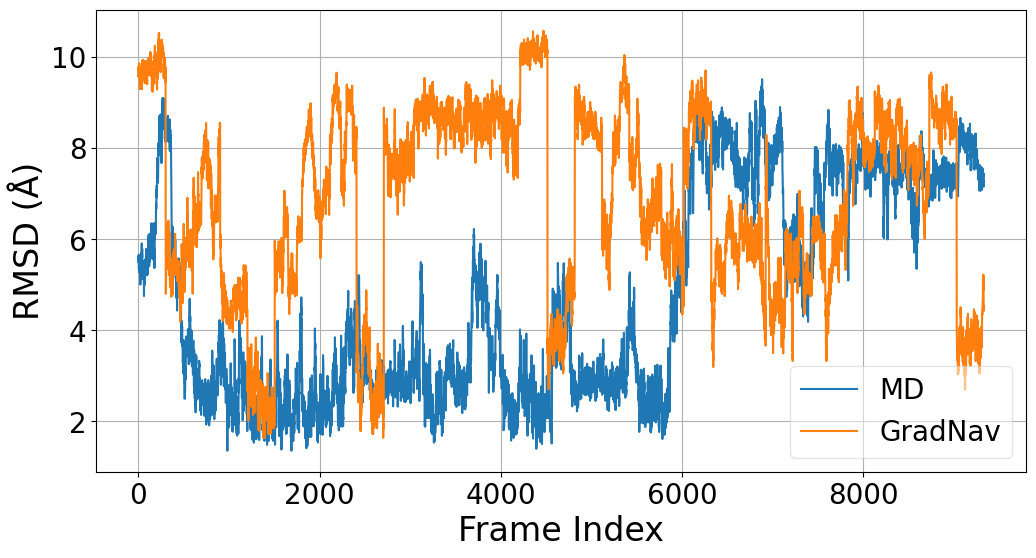

In [33]:
# Plotting
plt.figure(figsize=(12, 6))

plt.plot(10*rmsd_md[:len(rmsd_gradnav)], label=label_1)
plt.plot(10*rmsd_gradnav, label=label_2)
plt.xlabel('Frame Index', fontsize=ft+6)
plt.ylabel('RMSD (Å)', fontsize=ft+6)
# plt.title('RMSD Over Iterations')
plt.xticks(fontsize=ft+2)
plt.yticks(fontsize=ft+2)
plt.legend(fontsize=ft+2, framealpha=0.5)
plt.grid(True)
plt.savefig(os.path.join(directory, 'rmsd_plot.png'),dpi=300, bbox_inches='tight')